<a href="https://colab.research.google.com/github/marco10507/ml-portfolio/blob/main/sms_spam_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#SMS Spam Collection

This is a text corpus of over 5,500 English SMS messages with ~13% labeled as spam. The text file contains one message per line with two columns: the label ("ham" or "spam") and the raw text of the message. Messages labeled as "ham" are non-spam messages that can be considered legitimate.


## Import necessary libraries and download necessary NLTK data

This step involves importing the required Python libraries and modules, such as pandas for data manipulation and NLTK for natural language processing tasks. Additionally, it includes downloading essential NLTK data resources: stopwords, punkt, wordnet, etc. These resources are necessary for text processing and analysis.

In [20]:
!pip install contractions

# Import necessary libraries
import gdown
import pandas as pd
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
import nltk
import contractions
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Load and preview the SMS Spam Collection datase
This step involves loading the SMS Spam Collection dataset.

In [21]:
file_id = '1eBpaq2ZyIHM0-JrPgdJdtiFwrRyS2dOE'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'SMSSpamCollection.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1eBpaq2ZyIHM0-JrPgdJdtiFwrRyS2dOE
To: /content/SMSSpamCollection.csv
100%|██████████| 486k/486k [00:00<00:00, 67.0MB/s]


'SMSSpamCollection.csv'

 Printing shape of the data to verify its dimensions, and displaying the first few rows to preview the data structure and content.

In [22]:
spam = pd.read_csv("/content/SMSSpamCollection.csv", header=None)
print(spam.shape)
spam.head(10)

(5572, 2)


,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


[Source](https://www.dt.fee.unicamp.br) of dataset. This corpus was created by [Tiago A. Almeida](https://www.servidores.ufscar.br) and José María Gómez Hidalgo.

Citations:

Almeida, T.A., Gómez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

Gómez Hidalgo, J.M., Almeida, T.A., Yamakami, A. On the Validity of a New SMS Spam Collection. Proceedings of the 11th IEEE International Conference on Machine Learning and Applications (ICMLA'12), Boca Raton, FL, USA, 2012.

Almeida, T.A., Gómez Hidalgo, J.M., Silva, T.P. Towards SMS Spam Filtering: Results under a New Dataset. International Journal of Information Security Science (IJISS), 2(1), 1-18, 2013.

## Text Data Preprocessing for NLP

When preparing text data for natural language processing (NLP), a robust preprocessing pipeline is essential. Here's how the messages in the dataset are processed:

* 📝 Lemmatization: Converts words to their base forms using WordNet Lemmatizer and POS tagging. Example: "running" -> "run". Ensures consistency in analysis.

* 🔍 Contractions Unraveled: Expands contractions (e.g., "can't" to "cannot") for clarity and precise semantic understanding.

* 🔢 Digit Detox: Removes numerical digits from text to focus solely on textual context, reducing noise and enhancing analysis quality.

* ❌ Punctuation Purgatory: Strips punctuation marks to simplify text processing and improve readability for subsequent NLP tasks.

* 🚫 Stop Words Removal: Filters out common stop words (e.g., "the", "is", "and") to emphasize meaningful words and enhance data relevance.


Implementing these steps optimizes your text data, preparing it for more accurate classification of spam and ham messages. This approach is crucial for tasks such as text categorization or spam detection.

In [23]:
lemmatizer = WordNetLemmatizer()

def expand_contractions(text):
    expanded_text = contractions.fix(text)

    return expanded_text

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words)

    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in tagged_words]

    return ' '.join(lemmatized_words)

def remove_digits(text):
    translator = str.maketrans('', '', string.digits)
    result = text.translate(translator)

    return result

def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    result = text.translate(translator);

    return result

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]

    return ' '.join(filtered_text)


def curate_text(messages):
    curated_messages = messages.apply(expand_contractions)
    curated_messages = curated_messages.str.lower()
    curated_messages = curated_messages.apply(lemmatize_text)
    curated_messages = curated_messages.apply(remove_punctuation)
    curated_messages = curated_messages.apply(remove_stop_words)
    curated_messages = curated_messages.apply(remove_digits)

    return curated_messages

def sort(count, ascending=False):
    spam_count_df = pd.DataFrame.from_dict(count, orient='index', columns=['count']).reset_index()
    spam_count_df.rename(columns={'index': 'word'}, inplace=True)
    spam_count_df = spam_count_df.sort_values(by='count', ascending=ascending)

    return spam_count_df

spam = spam.rename(columns={ 0: 'type', 1: 'message' })
spam['message'] = curate_text(spam['message'])

### Data Analysis: Word Frequency and Word Clouds for Ham and Spam Messages

In this section, I will analyze the data for both ham and spam messages by showing the word frequency and visualizing the word cloud for each type of message. This analysis helps in understanding the most common words used in spam and ham messages, providing insights into their characteristics and differences.



###Counting and Sorting Word Frequency in Spam Messages

This code snippet counts and sorts the most common words in spam messages from the dataset. It helps in understanding the frequency distribution of words specifically in spam messages, which can be useful for text classification and spam detection tasks.

In [24]:
def count(messages):
    all_words = messages.str.split().explode()
    words_count = Counter(all_words)

    return words_count

spam_count = count(spam[spam['type'] == 'spam']['message'])
spam_count_sorted_df = sort(spam_count)

print('spam word count')
print(spam_count_sorted_df.shape)
print('top 10 spam words')
print(spam_count_sorted_df.head(10))

spam word count
(1967, 2)
top 10 spam words
       word  count
46     call    368
35        £    272
0      free    221
15      txt    156
11     text    139
4       win    136
51   mobile    134
268    stop    121
45    claim    115
69    reply    112


### Counting and Sorting Word Frequency in Ham Messages
This code snippet counts and sorts the most common words in ham (non-spam) messages from the dataset. It helps in understanding the frequency distribution of words specifically in ham messages, providing insights that can be useful for text classification and distinguishing ham from spam messages.

In [25]:
ham_count = count(spam[spam['type'] == 'ham']['message'])
ham_count_sorted_df = sort(ham_count)

print('ham word count')
print(ham_count_sorted_df.shape)
print('top 10 ham words')
print(ham_count_sorted_df.head(10))

ham word count
(6017, 2)
top 10 ham words
     word  count
13    get    609
0      go    591
288  come    323
213    gt    318
212    lt    316
126  know    298
215  call    294
16     ok    280
141  love    262
280  good    256


###Generating and Displaying Word Clouds for Ham and Spam Messages
This code snippet generates and displays word clouds for both spam and ham messages from the dataset. A word cloud is a visual representation where the size of each word indicates its frequency, helping to quickly identify the most prominent words in the dataset.


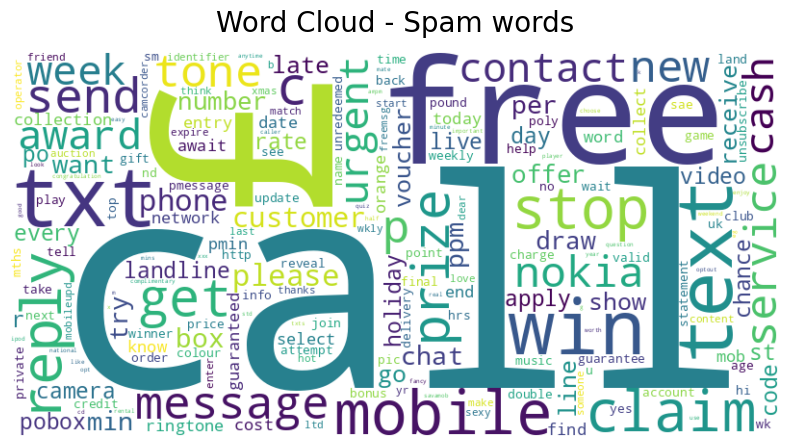

In [26]:
def show_word_cloud(count_frequencies, title):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        random_state=43
    ).generate_from_frequencies(count_frequencies)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20, pad=15)  # Add a title
    plt.axis('off')  # Turn off the axis

show_word_cloud(spam_count, 'Word Cloud - Spam words')

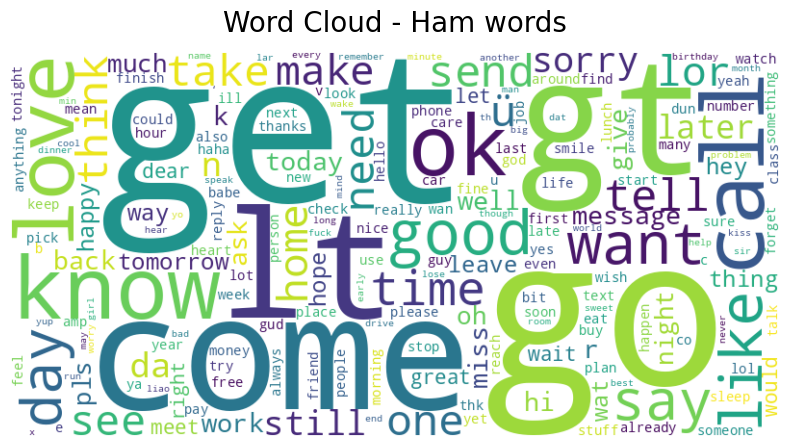

In [27]:
show_word_cloud(ham_count, 'Word Cloud - Ham words')

##  📨 Multinomial Naive Bayes Classifier for Spam Detection with Confidence Thresholding
n this section, we're building a machine learning model using Multinomial Naive Bayes (MNB) to classify messages as either spam or ham (non-spam).

Multinomial Naive Bayes (MNB) is a straightforward yet effective probabilistic classifier for text data, assuming features (like word frequencies) are independent given the class.

Our model goes beyond simple classification by incorporating a confidence threshold. It will classify a message as spam only when it's highly certain the message fits spam criteria. This strategy aims to minimize false positives (labeling ham as spam), though some spam might be misclassified as ham.

This approach ensures the model accurately distinguishes between spam and ham messages, prioritizing the correct classification of legitimate messages while tolerating potential spam misclassifications.

### 🛠️ Creating the Spam Detection Model
In this initial step of creating our spam detection model, we prepare the data for training and testing using CountVectorizer for feature extraction and encoding. CountVectorizer transforms text data into a numerical matrix representing the frequency of each word.

The dataset is split into training and testing sets using a test size of 20%, ensuring that the model is trained on a majority of the data while maintaining a separate portion for evaluating its performance. This division is essential for assessing how well the model distinguishes between spam and ham messages.

In [28]:
vectorizer = CountVectorizer()
spam['type'] = spam['type'].map({'ham': 0, 'spam': 1})

X = vectorizer.fit_transform(spam['message'])
y = spam['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (4457, 7049)
X_test shape: (1115, 7049)
y_train shape: (4457,)
y_test shape: (1115,)


##🧠 Training the Spam Detection Model
In this step, the spam detection model is fitted using the training data (**X_train** and **y_train**).

The model generates probabilities (y_proba) indicating the likelihood of each message being classified as spam (1). These probabilities will later be used to determine the optimal threshold for classification.

This process prepares the model for subsequent evaluation and adjustment to enhance its accuracy in distinguishing between spam and ham messages.

In [29]:
clf = MultinomialNB()
clf.fit(X_train, y_train)

y_proba = clf.predict_proba(X_test)[:,1]

## 📊 Evaluating the Spam Detection Model: ROC Curve and Threshold Optimization
In this step, I evaluate the spam detection model using the Receiver Operating Characteristic (ROC) curve and determine the optimal classification threshold.

The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) for various threshold values, providing a visual representation of the model's performance. The area under the ROC curve (AUC) quantifies the overall ability of the model to discriminate between spam and ham messages.

Two key thresholds are identified:

1. Low FPR Threshold: The threshold where the false positive rate is below a desired value. This helps in minimizing the misclassification of ham as spam.
2. Optimal Threshold: The threshold that maximizes the difference between TPR and FPR, indicating the best balance between true positives and false positives.

The ROC curve is plotted with these thresholds marked, showing the trade-offs and helping to select the most appropriate threshold for the classification task.

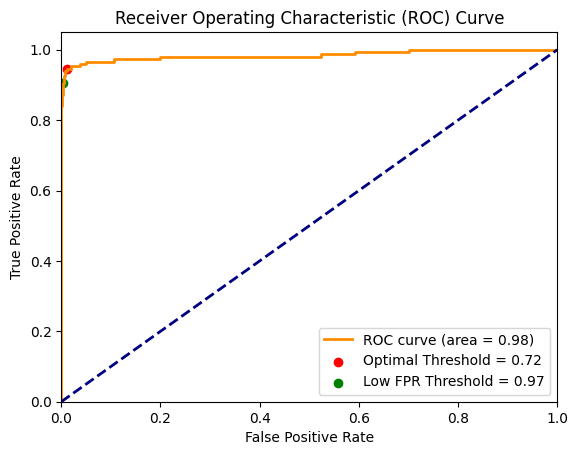

In [30]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

# Determine lowest fpr
desired_fpr = 0.005
low_fpr_idx = (fpr < desired_fpr).nonzero()[0][-1]
low_fpr_threshold = thresholds[low_fpr_idx]

# Determine the optimal threshold
J = tpr - fpr
optimal_idx = J.argmax()
optimal_threshold = thresholds[optimal_idx]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', marker='o', label=f'Optimal Threshold = {optimal_threshold:.2f}')
plt.scatter(fpr[low_fpr_idx], tpr[low_fpr_idx], color='green', marker='o', label=f'Low FPR Threshold = {low_fpr_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

### Evaluating the Model with Adjusted Threshold
In this step, I evaluate the performance of the spam detection model using a newly adjusted threshold, specifically chosen to minimize the false positive rate.

This evaluation helps to ensure that the model effectively reduces false positives while maintaining good overall performance in classifying spam and ham messages.


Classification Report (Test data):

              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.91      0.94       149

    accuracy                           0.98      1115
   macro avg       0.98      0.95      0.97      1115
weighted avg       0.98      0.98      0.98      1115



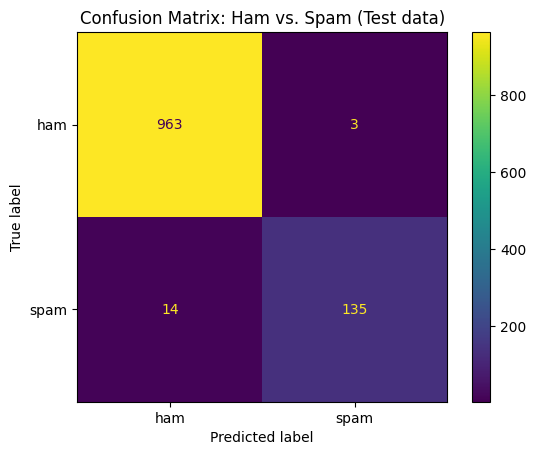

In [31]:
y_pred_new_threshold = (y_proba >= low_fpr_threshold)

# Evaluate the performance
print("Classification Report (Test data):\n")
print(classification_report(y_test, y_pred_new_threshold, target_names=['ham', 'spam']))

cm = confusion_matrix(y_test, y_pred_new_threshold)
# Create a ConfusionMatrixDisplay instance with the confusion matrix and labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham', 'spam'])

# Plot the confusion matrix
disp.plot()

# Set the title
plt.title('Confusion Matrix: Ham vs. Spam (Test data)')
plt.show()

## Conclusion on Spam Detection Model
The spam detection model demonstrates strong performance in distinguishing spam from ham messages:

* Precision: Achieves a high precision of 98% for spam classification, ensuring that 98% of messages identified as spam are correct, minimizing false positives.

* Recall: Demonstrates 91% recall for spam, accurately identifying 91% of all actual spam messages.

* F1-score: Attains an F1-score of 0.94 for spam detection, indicating a balanced performance between precision and recall.

* Accuracy: Maintains an overall accuracy of 98%, emphasizing its reliability in correctly classifying messages.

## Effectiveness in Spam Detection
The model effectively reduces the presence of spam by accurately filtering out unwanted messages while minimizing the number of legitimate ham messages incorrectly flagged as spam. This approach prioritizes high precision for spam detection, ensuring that users do not miss important emails while enhancing email security and user experience.